# Customer Churn Prediction

### Problem: Predict whether a telecom customer will churn (binary classification) using structured customer, service and account data.

imports

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

Load dataset & quick EDA

In [3]:
# Load CSV - adjust path if needed
df = pd.read_csv("data/Telco-Customer-Churn.csv")

In [4]:
print("rows, cols:", df.shape)
display(df.head())
display(df.dtypes)


rows, cols: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# Basic target distribution
print(df['Churn'].value_counts(dropna=False))
print("Churn percent:", df['Churn'].value_counts(normalize=True).to_dict())

Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn percent: {'No': 0.7346301292063041, 'Yes': 0.2653698707936959}


Cleaning & basic preprocessing

In [6]:
data = df.copy()

In [7]:
# Some datasets have TotalCharges as string due to blank values -> coerce
if data['TotalCharges'].dtype == 'object':
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [8]:
# Drop customerID (identifier)
data.drop(columns=['customerID'], inplace=True)

In [9]:
missing_tc = data['TotalCharges'].isna().sum()
print("TotalCharges missing:", missing_tc)
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'] * data['tenure'])

TotalCharges missing: 11


In [10]:
# Convert target to 0/1
data['Churn'] = data['Churn'].map({'Yes':1, 'No':0}).astype(int)

In [11]:
# Trim whitespace in string columns (defensive)
for c in data.select_dtypes(include='object').columns:
    data[c] = data[c].str.strip()

Split feature types

In [12]:
# Identify categorical vs numeric
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = [c for c in data.columns if c not in numerical_cols + ['Churn']]

In [13]:
print("Numeric:", numerical_cols)
print("Categorical:", categorical_cols)

Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


Train/val/test split (stratified)

In [14]:
# First split train+temp / test
train_df, test_df = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Churn'])
# Then split train to train/val
train_df, val_df = train_test_split(train_df, test_size=0.1765, random_state=42, stratify=train_df['Churn'])
# 0.1765 * 0.85 ≈ 0.15 => final ~70/15/15

In [15]:
print("Train / Val / Test shapes:", train_df.shape, val_df.shape, test_df.shape)

Train / Val / Test shapes: (4929, 20) (1057, 20) (1057, 20)


Prepare encoders & scalers; create TensorFlow input pipelines

In [16]:
# Prepare LabelEncoders for categorical features to get integer indices for embeddings
label_encoders = {}
cat_cardinalities = {}  # cardinality per categorical feature

In [17]:
for col in categorical_cols:
    le = LabelEncoder()
    # fillna with 'MISSING' if any
    train_vals = train_df[col].fillna('MISSING').astype(str)
    le.fit(train_vals)
    label_encoders[col] = le
    cat_cardinalities[col] = len(le.classes_)
    print(col, "-> cardinality:", cat_cardinalities[col])

gender -> cardinality: 2
SeniorCitizen -> cardinality: 2
Partner -> cardinality: 2
Dependents -> cardinality: 2
PhoneService -> cardinality: 2
MultipleLines -> cardinality: 3
InternetService -> cardinality: 3
OnlineSecurity -> cardinality: 3
OnlineBackup -> cardinality: 3
DeviceProtection -> cardinality: 3
TechSupport -> cardinality: 3
StreamingTV -> cardinality: 3
StreamingMovies -> cardinality: 3
Contract -> cardinality: 3
PaperlessBilling -> cardinality: 2
PaymentMethod -> cardinality: 4


In [18]:
# Scale numeric features
scaler = StandardScaler()
scaler.fit(train_df[numerical_cols])


,copy,True
,with_mean,True
,with_std,True


In [19]:
# Function to build input dicts for Keras
def df_to_keras_inputs(df_in):
    X_num = scaler.transform(df_in[numerical_cols])
    X_cat = {}
    for col, le in label_encoders.items():
        vals = df_in[col].fillna('MISSING').astype(str)
        X_cat[col] = le.transform(vals)
    y = df_in['Churn'].values
    # Return dict with numeric and categorical arrays
    return X_num, X_cat, y

In [20]:
X_num_tr, X_cat_tr, y_tr = df_to_keras_inputs(train_df)

Build Keras model: embeddings + dense head

In [21]:
def build_embedding_ann(cat_cardinalities, num_numeric, embedding_dim_rule="auto", dense_units=[128,64], dropout=0.3):
    # Inputs
    cat_inputs = []
    embed_outputs = []
    for i, (col, card) in enumerate(cat_cardinalities.items()):
        inp = keras.Input(shape=(1,), name=f"{col}_in", dtype='int32')
        # rule of thumb for embedding size: min(50, (card+1)//2) or sqrt(card)
        if embedding_dim_rule == "auto":
            dim = int(min(50, max(2, round(np.sqrt(card)))))
        else:
            dim = embedding_dim_rule
        emb = layers.Embedding(input_dim=card, output_dim=dim, name=f"{col}_emb")(inp)
        emb = layers.Reshape((dim,))(emb)
        cat_inputs.append(inp)
        embed_outputs.append(emb)
    # Numeric input
    num_input = keras.Input(shape=(num_numeric,), name='numeric_in')
    # Concatenate
    x = layers.Concatenate()(embed_outputs + [num_input])
    # Dense head
    for units in dense_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid', name='output')(x)

    inputs = cat_inputs + [num_input]
    model = keras.Model(inputs=inputs, outputs=out)
    return model

In [22]:
# Build model
num_numeric = len(numerical_cols)
model = build_embedding_ann(cat_cardinalities, num_numeric, dense_units=[128,64], dropout=0.2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gender_in           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SeniorCitizen_in    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Partner_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dependents_in       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PhoneService_in     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MultipleLines_in    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InternetService_in  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OnlineSecurity_in   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OnlineBackup_in     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DeviceProtection_in │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TechSupport_in      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ StreamingTV_in      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ StreamingMovies_in  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Contract_in         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PaperlessBilling_in │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PaymentMethod_in    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_emb          │ (None, 1, 2)      │          4 │ gender_in[0][0] 

 Total params: 13,783 (53.84 KB)

 Trainable params: 13,399 (52.34 KB)

 Non-trainable params: 384 (1.50 KB)

Prepare Keras inputs for training

In [23]:
def make_keras_inputs(X_num, X_cat):
    # returns list of arrays in the same ordering as model.inputs
    inputs = []
    # categorical inputs in same order as model expects (cat_cardinalities.keys())
    for col in cat_cardinalities.keys():
        inputs.append(X_cat[col].astype('int32'))
    inputs.append(X_num.astype('float32'))
    return inputs

In [24]:
train_inputs = make_keras_inputs(X_num_tr, X_cat_tr)
X_num_val, X_cat_val, y_val = df_to_keras_inputs(val_df)
val_inputs = make_keras_inputs(X_num_val, X_cat_val)
X_num_test, X_cat_test, y_test = df_to_keras_inputs(test_df)
test_inputs = make_keras_inputs(X_num_test, X_cat_test)

Compile & training configuration

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.AUC(name='auc')]
)

In [26]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint('saved_models/best_model.h5', save_best_only=True, monitor='val_auc', mode='max')
]

In [27]:
# Fit
history = model.fit(
    x=train_inputs,
    y=y_tr,
    validation_data=(val_inputs, y_val),
    epochs=100,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6143 - auc: 0.6516 - loss: 0.7739

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.6677 - auc: 0.7374 - loss: 0.6999 - val_accuracy: 0.7493 - val_auc: 0.7794 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 2/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7131 - auc: 0.7701 - loss: 0.5886

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7156 - auc: 0.7696 - loss: 0.5760 - val_accuracy: 0.7342 - val_auc: 0.7799 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 3/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7463 - auc: 0.7887 - loss: 0.5442

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7480 - auc: 0.7897 - loss: 0.5371 - val_accuracy: 0.7342 - val_auc: 0.8039 - val_loss: 0.5659 - learning_rate: 0.0010
Epoch 4/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7534 - auc: 0.7831 - loss: 0.5277

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7586 - auc: 0.7932 - loss: 0.5130 - val_accuracy: 0.7342 - val_auc: 0.8126 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 5/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7717 - auc: 0.8117 - loss: 0.4877

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7691 - auc: 0.8076 - loss: 0.4925 - val_accuracy: 0.7342 - val_auc: 0.8127 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 6/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7850 - auc: 0.8004 - loss: 0.4856

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7809 - auc: 0.8059 - loss: 0.4783 - val_accuracy: 0.7342 - val_auc: 0.8199 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 7/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7598 - auc: 0.7957 - loss: 0.4849

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7681 - auc: 0.8058 - loss: 0.4711 - val_accuracy: 0.7342 - val_auc: 0.8226 - val_loss: 0.5304 - learning_rate: 0.0010
Epoch 8/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7844 - auc: 0.8214 - loss: 0.4569

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7896 - auc: 0.8223 - loss: 0.4536 - val_accuracy: 0.7342 - val_auc: 0.8277 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7902 - auc: 0.8246 - loss: 0.4491 - val_accuracy: 0.7342 - val_auc: 0.8254 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7860 - auc: 0.8244 - loss: 0.4477 - val_accuracy: 0.7342 - val_auc: 0.8276 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7958 - auc: 0.8201 - loss: 0.4423

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7943 - auc: 0.8228 - loss: 0.4454 - val_accuracy: 0.7342 - val_auc: 0.8294 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7903 - auc: 0.8291 - loss: 0.4422

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7918 - auc: 0.8338 - loss: 0.4356 - val_accuracy: 0.7342 - val_auc: 0.8306 - val_loss: 0.5015 - learning_rate: 0.0010
Epoch 13/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7915 - auc: 0.8383 - loss: 0.4302

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7935 - auc: 0.8311 - loss: 0.4386 - val_accuracy: 0.7342 - val_auc: 0.8311 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7884 - auc: 0.8334 - loss: 0.4347 - val_accuracy: 0.7342 - val_auc: 0.8302 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7981 - auc: 0.8376 - loss: 0.4275 - val_accuracy: 0.7351 - val_auc: 0.8293 - val_loss: 0.4860 - learning_rate: 0.0010
Epoch 16/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8038 - auc: 0.8380 - loss: 0.4290 - val_accuracy: 0.7360 - val_auc: 0.8307 - val_loss: 0.4848 - learning_rate: 0.0010
Epoch 17/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8012 - auc: 0.8387 - loss: 0.4264 - val_accuracy: 0.7398 - val_auc: 0.8307 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 18/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7921 - auc: 0.8413 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8002 - auc: 0.8449 - loss: 0.4211 - val_accuracy: 0.7370 - val_auc: 0.8319 - val_loss: 0.4751 - learning_rate: 0.0010
Epoch 19/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7927 - auc: 0.8447 - loss: 0.4194 - val_accuracy: 0.7550 - val_auc: 0.8290 - val_loss: 0.4683 - learning_rate: 0.0010
Epoch 20/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8008 - auc: 0.8410 - loss: 0.4241 - val_accuracy: 0.7682 - val_auc: 0.8287 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 21/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7975 - auc: 0.8430 - loss: 0.4230 - val_accuracy: 0.7796 - val_auc: 0.8307 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 22/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8018 - auc: 0.8428 - loss: 0.4217 - val_accuracy: 0.7815 - val_auc: 0.8288 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 23/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8054 - auc: 0.8478 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8069 - auc: 0.8497 - loss: 0.4128 - val_accuracy: 0.7909 - val_auc: 0.8319 - val_loss: 0.4369 - learning_rate: 0.0010
Epoch 27/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8054 - auc: 0.8471 - loss: 0.4174 - val_accuracy: 0.7975 - val_auc: 0.8314 - val_loss: 0.4350 - learning_rate: 0.0010
Epoch 28/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8069 - auc: 0.8505 - loss: 0.4119 - val_accuracy: 0.7919 - val_auc: 0.8309 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 29/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8077 - auc: 0.8508 - loss: 0.4120 - val_accuracy: 0.7909 - val_auc: 0.8315 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 30/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8170 - auc: 0.8539 - loss: 0.4090 - val_accuracy: 0.7975 - val_auc: 0.8317 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 31/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8076 - auc: 0.8576 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8089 - auc: 0.8526 - loss: 0.4097 - val_accuracy: 0.8013 - val_auc: 0.8327 - val_loss: 0.4309 - learning_rate: 0.0010
Epoch 32/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8107 - auc: 0.8529 - loss: 0.4105 - val_accuracy: 0.7966 - val_auc: 0.8305 - val_loss: 0.4328 - learning_rate: 0.0010
Epoch 33/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8048 - auc: 0.8522 - loss: 0.4095 - val_accuracy: 0.7985 - val_auc: 0.8304 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 34/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8032 - auc: 0.8582 - loss: 0.4021 - val_accuracy: 0.7947 - val_auc: 0.8260 - val_loss: 0.4372 - learning_rate: 0.0010
Epoch 35/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8119 - auc: 0.8587 - loss: 0.4001 - val_accuracy: 0.7975 - val_auc: 0.8301 - val_loss: 0.4356 - learning_rate: 0.0010
Epoch 36/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8099 - auc: 0.8588 - 

Training visualizations

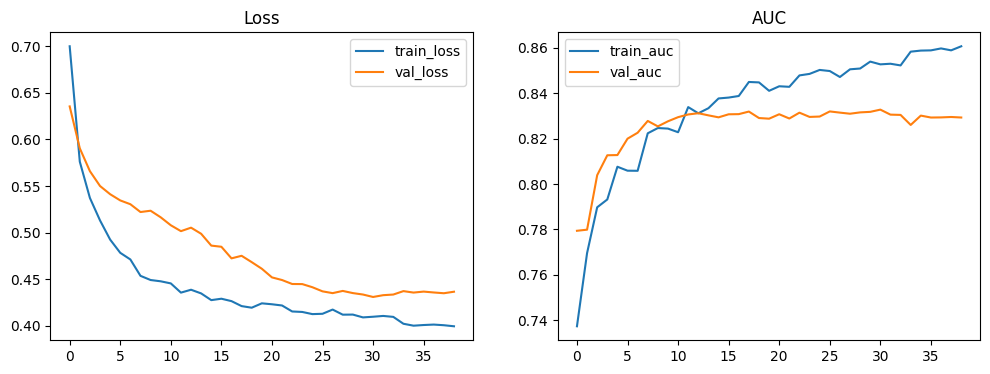

In [28]:
# Plot loss and AUC
hist = history.history
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(hist['loss'], label='train_loss'); ax[0].plot(hist['val_loss'], label='val_loss'); ax[0].legend(); ax[0].set_title('Loss')
ax[1].plot(hist['auc'], label='train_auc'); ax[1].plot(hist['val_auc'], label='val_auc'); ax[1].legend(); ax[1].set_title('AUC')
plt.show()

Evaluation on test set (metrics + confusion matrix)

In [29]:
# Predict probabilities and labels
y_pred_prob = model.predict(test_inputs).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


In [30]:
# Metrics
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred, digits=4))

ROC AUC: 0.8512617209045781
              precision    recall  f1-score   support

           0     0.8310    0.9176    0.8722       777
           1     0.6784    0.4821    0.5637       280

    accuracy                         0.8023      1057
   macro avg     0.7547    0.6999    0.7179      1057
weighted avg     0.7906    0.8023    0.7905      1057



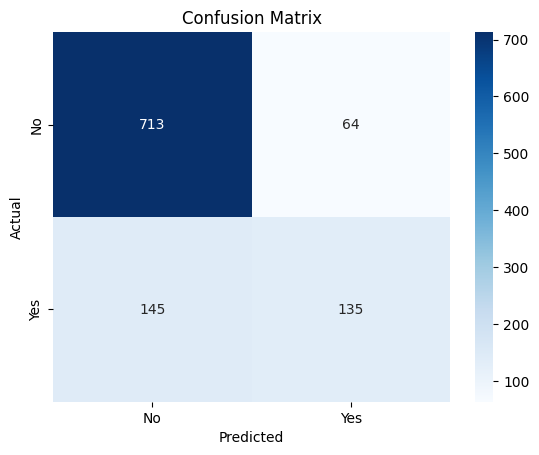

In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

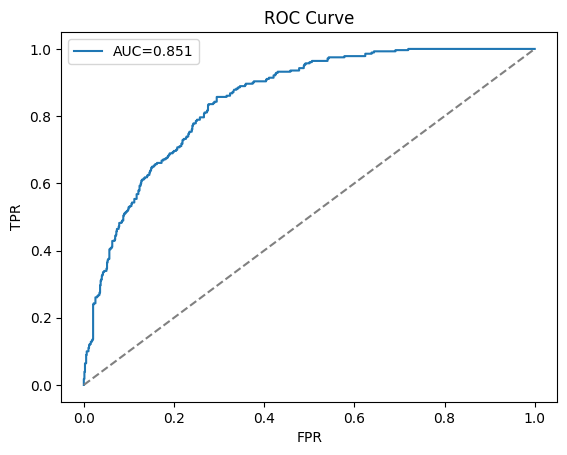

In [32]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_pred_prob):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
plt.show()

Model saving & simple inference

In [34]:
model.save('saved_models/full_model.h5')